In [139]:
import torch
import numpy as np
from dataloader import get_dataloaders
from models.msdnet import MSDNet
from utils import parse_args
from collections import OrderedDict
import matplotlib.pyplot as plt
import random
from typing import Dict
import scipy

In [94]:
# MODEL_FOLDER = 'models_poe'
# LIKELIHOOD = 'OVR'
# EPOCH = 299

MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

# MODEL_FOLDER = 'models_poe_untempered'
# LIKELIHOOD = 'OVR'
# EPOCH = 149

## 0.1 Utils

In [140]:
# TODO: all functions below have an ugly implementation with for loops...

def modal_probs_decreasing(_preds: Dict[int, torch.Tensor], _probs: torch.Tensor, layer: int, verbose: bool = False) -> Dict[float, float]:
    """
    nr. of decreasing modal probability vectors in anytime-prediction regime
    """
    nr_non_decreasing = {-0.01: 0, -0.05: 0, -0.1: 0, -0.2: 0, -0.5: 0}
    diffs = []
    for i in range(10000):
        probs_i = _probs[:, i, _preds[layer - 1][i]].cpu().numpy()
        diffs_i = np.diff(probs_i)
        diffs.append(diffs_i.min())
        for threshold in nr_non_decreasing.keys():
            if np.all(diffs_i >= threshold):
                nr_non_decreasing[threshold] += 1
            else:
                if verbose:
                    print(i, probs_i)
    # print(nr_non_decreasing)
    # print(np.mean(diffs))
    nr_decreasing = {-1. * k: ((10000 - v) / 10000) * 100 for k, v in nr_non_decreasing.items()}
    return nr_decreasing


def modal_probs_average(_preds: Dict[int, torch.Tensor], _probs: torch.Tensor, layer: int) -> Dict[float, float]:
    """
    average modal probability in anytime-prediction regime
    """
    preds = []
    for i in range(10000):
        preds.append(_probs[:, i, _preds[layer - 1][i]])
    return torch.stack(preds, dim=1).mean(axis=1)


def ovr_likelihood(tensor: torch.Tensor) -> torch.tensor:
    tensor = torch.clone(tensor)
    # TODO: implement without for loops
    assert len(tensor.shape) == 3  # (L, N_test, C)
    for l in range(tensor.shape[0]):
        for n in range(tensor.shape[1]):
            ovr_mask = tensor[l, n, :] > 0
            nr_non_zero = ovr_mask.sum()
            if nr_non_zero == 0:
                nr_non_zero = 1  # to avoid division by 0
            tensor[l, n, :] = ovr_mask.long() / nr_non_zero
    return tensor


def f_probs_ovr_poe(tensor: torch.Tensor) -> torch.tensor:
    tensor = torch.clone(tensor)
    # TODO: implement without for loops
    assert len(tensor.shape) == 3  # (L, N_test, C)
    tensor = tensor.cumprod(dim=0)
    for l in range(tensor.shape[0]):
        for n in range(tensor.shape[1]):
            ovr_mask = tensor[l, n, :] > 0
            if ovr_mask.sum() > 0:
                tensor[l, n, :] = ovr_mask.long() / ovr_mask.sum()
    return tensor


def f_probs_ovr_poe_break_ties(logits, probs_ovr_poe, T=1., softmax=False):
    logits, probs_ovr_poe = torch.clone(logits), torch.clone(probs_ovr_poe)
    # TODO: implement without for loops
    assert len(logits.shape) == 3  # (L, N_test, C)
    assert len(probs_ovr_poe.shape) == 3  # (L, N_test, C)
    preds = []
    for l in range(logits.shape[0]):
        preds_l = []
        for n in range(logits.shape[1]):
            ovr_mask = probs_ovr_poe[l, n, :] > 0
            preds_n = []
            sum_n = 0.
            for c in range(logits.shape[2]):
                if ovr_mask[c]:
                    sigmoid_prod = torch.sigmoid(T * logits[:l + 1, n, c]).prod()
                else:
                    sigmoid_prod = 0.
                sum_n += sigmoid_prod
                preds_n.append(sigmoid_prod)
            if sum_n > 0.:
                if softmax:
                    preds_n = list(scipy.special.softmax(preds_n))
                else:
                    preds_n = [x / sum_n for x in preds_n]
            preds_l.append(preds_n)
        preds.append(preds_l)
    return torch.tensor(preds)


def get_ood_ovr(_probs: torch.Tensor) -> Dict:
    ood_dict_ids = {l: [] for l in range(7)}
    for n in range(10000):
        for l in range(7):
            nr_non_zero = (_probs[l, n, :] > 0).sum()
            if nr_non_zero == 0:
                ood_dict_ids[l].append(n)
    return ood_dict_ids

## 0.2 Load pretrained model and dataloaders

In [96]:
ARGS = parse_args()
ARGS.data_root = 'data'
ARGS.data = 'cifar100'
ARGS.save= f'/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/models/{MODEL_FOLDER}'
ARGS.arch = 'msdnet'
ARGS.batch_size = 64
ARGS.epochs = 300
ARGS.nBlocks = 7
ARGS.stepmode = 'even'
ARGS.base = 4
ARGS.nChannels = 16
ARGS.j = 16
ARGS.num_classes = 100
ARGS.step = 2
ARGS.use_valid = True
ARGS.splits = ['train', 'val', 'test']
ARGS.likelihood = LIKELIHOOD

In [97]:
# load pre-trained model
model = MSDNet(args=ARGS)
MODEL_PATH = f'models/{MODEL_FOLDER}/save_models/checkpoint_{EPOCH}.pth.tar'
state = torch.load(MODEL_PATH)
params = OrderedDict()
for params_name, params_val in state['state_dict'].items():
    params[params_name.replace('module.', '')] = params_val
    # state['state_dict'][params_name.replace('module.', '')] = state['state_dict'].pop(params_name)
model.load_state_dict(params)
model = model.cuda()
model.eval()

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

MSDNet(
  (blocks): ModuleList(
    (0): Sequential(
      (0): MSDNFirstLayer(
        (layers): ModuleList(
          (0): ConvBasic(
            (net): Sequential(
              (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): ConvBasic(
            (net): Sequential(
              (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (2): ConvBasic(
            (net): Sequential(
              (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [98]:
# data
_, _, test_loader = get_dataloaders(ARGS)

logits = []
targets = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        y = y.cuda(device=None)
        x = x.cuda()

        input_var = torch.autograd.Variable(x)
        target_var = torch.autograd.Variable(y)

        output = model(input_var)
        if not isinstance(output, list):
            output = [output]

        logits.append(torch.stack(output))
        targets.append(target_var)

logits = torch.cat(logits, dim=1).cpu()
targets = torch.cat(targets).cpu()

Files already downloaded and verified
Files already downloaded and verified
!!!!!! Load train_set_index !!!!!!


### unit-testing

In [99]:
L = len(logits)
a = torch.softmax(logits, dim=2)
a_cumsum = a.cumsum(dim=0)
a_cumsum_mean = a.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]

n = 7390
c = 77

tmp = 0
for i in range(7):
    tmp += a[i, n, c]
    assert np.isclose(a_cumsum[i, n, c], tmp)
    assert np.isclose(a_cumsum_mean[i, n, c], (tmp / (i + 1)))
    # print(tmp, tmp / (i + 1))

## 1 Softmax

### 1.1 anytime-prediction: performance

In [100]:
L = len(logits)

In [152]:
probs.shape

torch.Size([7, 10000, 100])

In [159]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [102]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [103]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

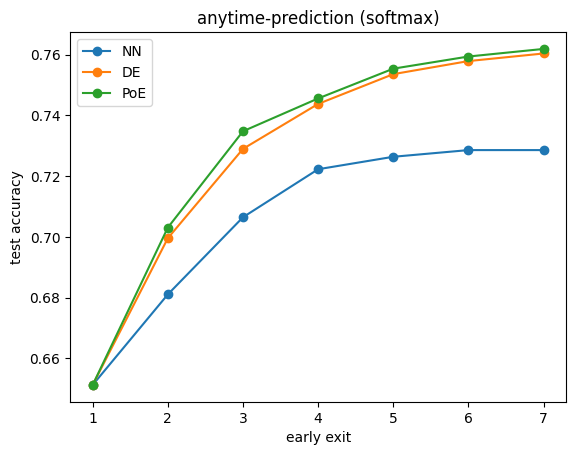

In [104]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc, label='NN', marker='o')
plt.plot(early_exits, acc_de, label='DE', marker='o')
plt.plot(early_exits, acc_poe, label='PoE', marker='o')
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

### 1.2 anytime-prediction: modal probability 

#### 1.2.1 plots

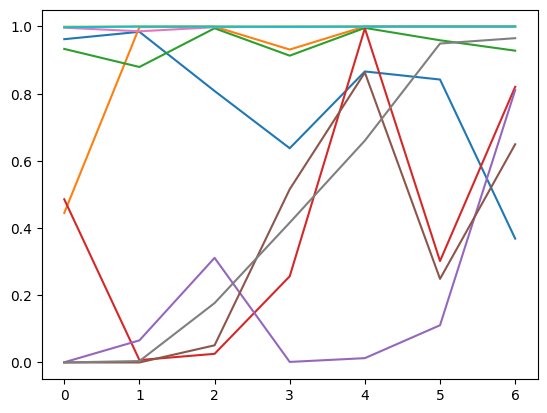

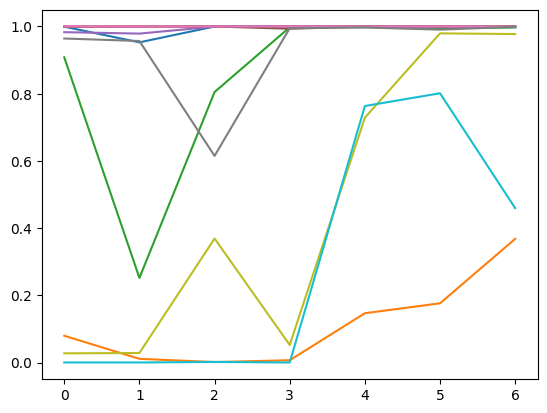

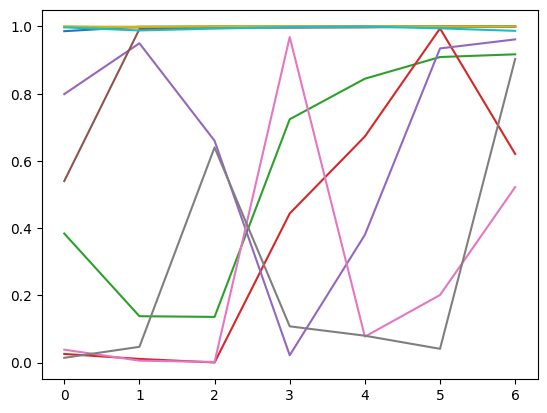

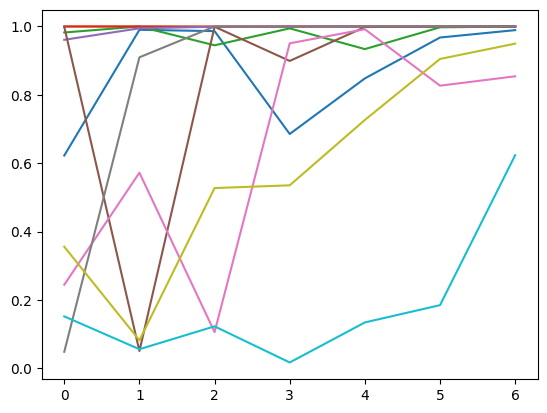

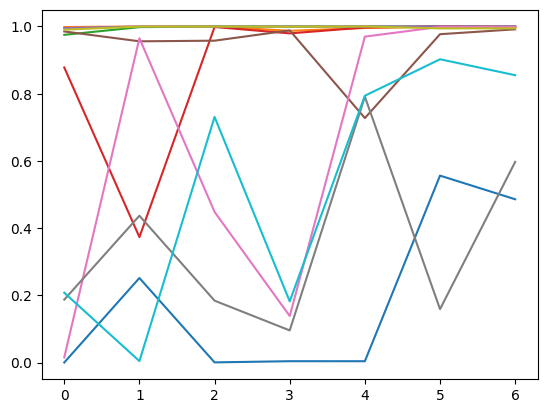

In [105]:
_preds = preds[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        plt.plot(list(range(len(probs_i))), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

#### 1.2.2 nr. of test examples with decreasing modal probabilities throughout sequential evaluation

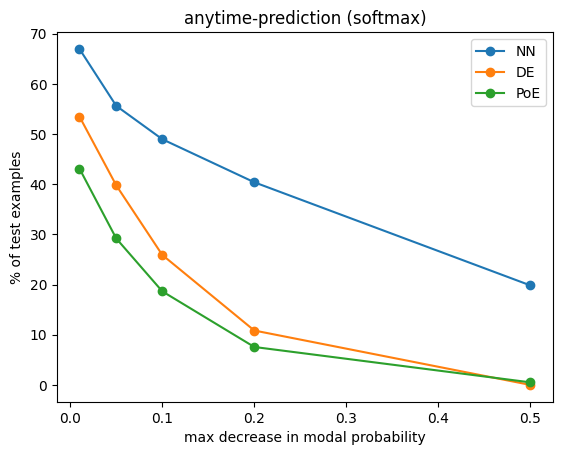

In [106]:
for _preds, _poe, label in [(preds, probs, 'NN'), (preds_de, probs_de, 'DE'), (preds_poe, probs_poe, 'PoE')]:
    modal_probs = modal_probs_decreasing(_preds, _poe, L)
    plt.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.xlabel('max decrease in modal probability')
plt.ylabel('% of test examples')
plt.show()

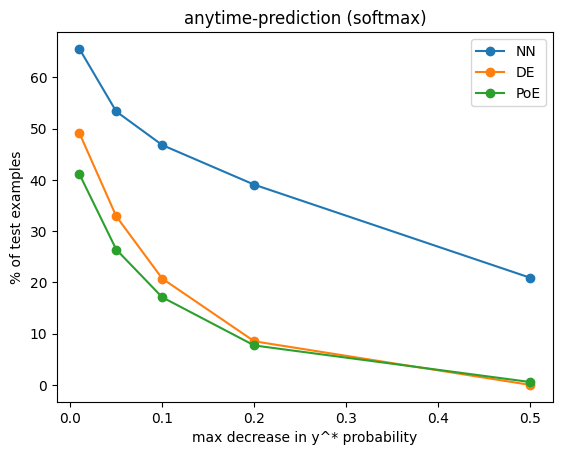

In [107]:
_targets = {l: targets for l in range(L)}
for _preds, _poe, label in [(_targets, probs, 'NN'), (_targets, probs_de, 'DE'), (_targets, probs_poe, 'PoE')]:
    modal_probs = modal_probs_decreasing(_preds, _poe, L)
    plt.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.xlabel('max decrease in y^* probability')
plt.ylabel('% of test examples')
plt.show()

### 1.2.3 MSP throughout sequntial evaluation

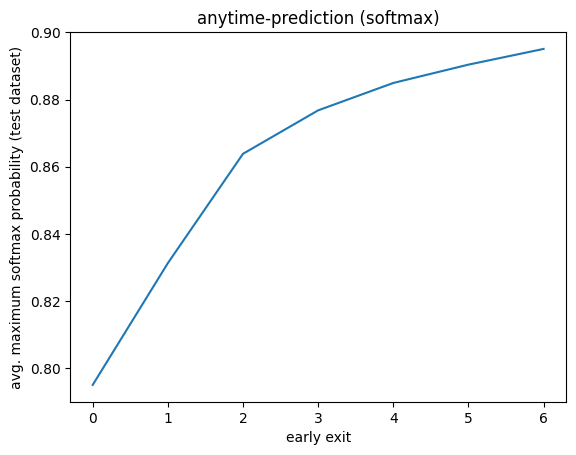

: 

In [169]:
plt.plot(list(range(len(msp))), [msp[j].mean() for j in range(len(msp))])
plt.title('anytime-prediction (softmax)')
plt.xlabel('early exit')
plt.ylabel('avg. maximum softmax probability (test dataset)')
plt.show()

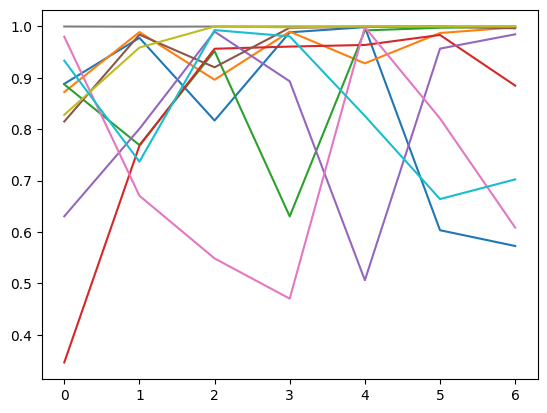

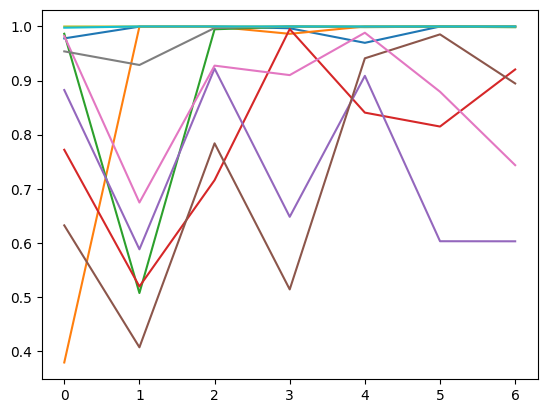

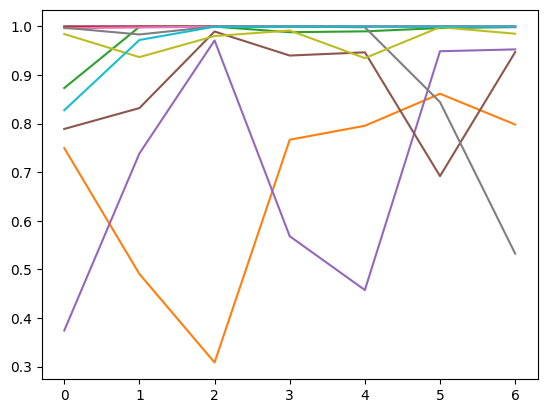

In [166]:
for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        msp_i = [msp[j][i] for j in range(len(msp))]
        plt.plot(list(range(len(msp_i))), msp_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

## 2 OVR

In [108]:
probs_ovr = ovr_likelihood(logits)
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets == preds_ovr[i]).sum() / len(targets) for i in range(L)]
ids_ood_ovr = get_ood_ovr(probs_ovr)
nr_ood_ovr = {l: len(l_dict) for l, l_dict in ids_ood_ovr.items()}

_ids = {l: [i for i in range(10000) if i not in l_ids] for l, l_ids in ids_ood_ovr.items()}
acc_ovr_excluding_ood = [(targets[_ids[i]] == preds_ovr[i][_ids[i]]).sum() / len(targets[_ids[i]]) for i in range(L)]

In [109]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]
ids_ood_poe_ovr = get_ood_ovr(probs_poe_ovr)
nr_ood_poe_ovr = {l: len(l_dict) for l, l_dict in ids_ood_poe_ovr.items()}

_ids = {l: [i for i in range(10000) if i not in l_ids] for l, l_ids in ids_ood_poe_ovr.items()}
acc_poe_ovr_excluding_ood = [(targets[_ids[i]] == preds_poe_ovr[i][_ids[i]]).sum() / len(targets[_ids[i]]) for i in range(L)]

In [110]:
# # first early-exit layers are too sharp...
# tmp = 0
# for n in range(10000):
#     if n in ids_ood_poe_ovr[0]:
#         print(n, probs_poe_ovr[:, n, preds_poe_ovr[6][n]])
#         assert probs_poe_ovr[:, n, preds_poe_ovr[6][n]].sum() == 0.
#         print(n, probs_ovr[:, n, preds_ovr[6][n]])
#         if probs_ovr[:, n, preds_ovr[6][n]].sum() > 0:
#             tmp += 1
# print(tmp)

In [111]:
acc_poe_ovr

[tensor(0.0225),
 tensor(0.0311),
 tensor(0.0379),
 tensor(0.0430),
 tensor(0.0472),
 tensor(0.0500),
 tensor(0.0520)]

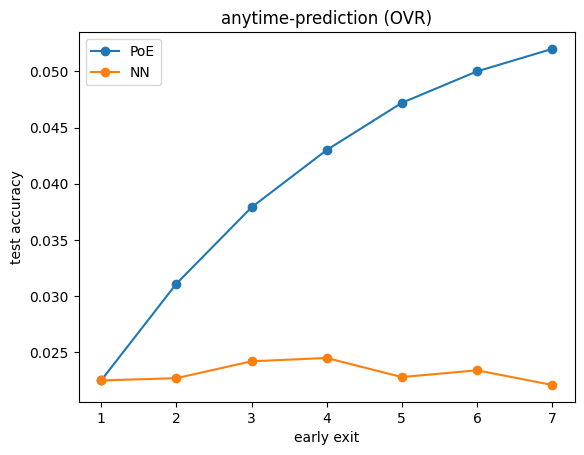

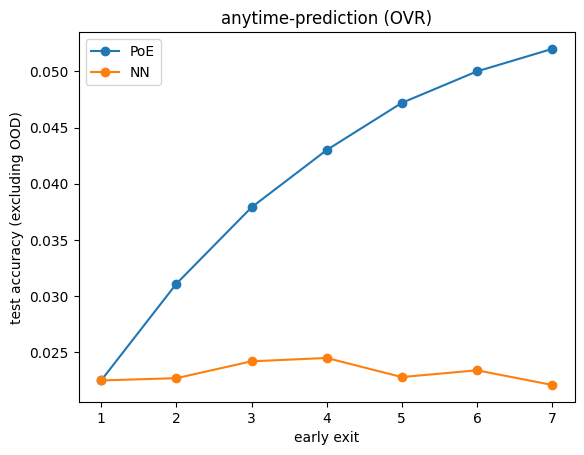

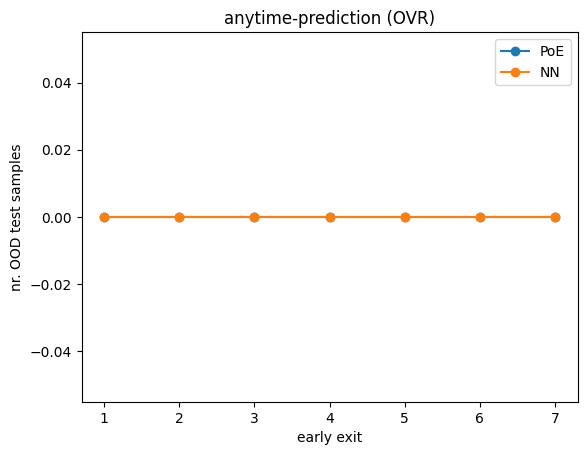

In [112]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc_poe_ovr, marker='o', label='PoE')
plt.plot(early_exits, acc_ovr, marker='o', label='NN')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, acc_poe_ovr_excluding_ood, marker='o', label='PoE')
plt.plot(early_exits, acc_ovr_excluding_ood, marker='o', label='NN')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('test accuracy (excluding OOD)')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, nr_ood_poe_ovr.values(), marker='o', label='PoE')
plt.plot(early_exits, nr_ood_ovr.values(), marker='o', label='NN')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('nr. OOD test samples')
plt.xlabel('early exit')
plt.show()

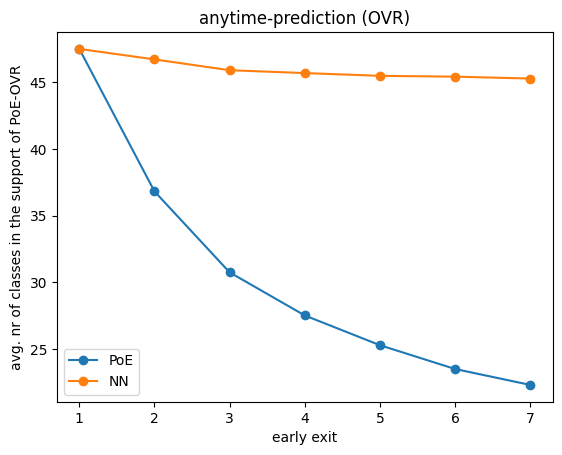

In [113]:
plt.plot(list(range(1, L + 1)), [np.mean((probs_poe_ovr[l] > 0).sum(axis=1).numpy()) for l in range(L)], marker='o', label='PoE')
plt.plot(list(range(1, L + 1)), [np.mean((probs_ovr[l] > 0).sum(axis=1).numpy()) for l in range(L)], marker='o', label='NN')
plt.title('anytime-prediction (OVR)')
plt.ylabel('avg. nr of classes in the support of PoE-OVR')
plt.xlabel('early exit')
plt.legend()
plt.show()

In [114]:
modal_probs_ovr = modal_probs_decreasing(preds_poe_ovr, probs_poe_ovr, L)
for thres, val in modal_probs_ovr.items():
    print(thres, val)

0.01 0.0
0.05 0.0
0.1 0.0
0.2 0.0
0.5 0.0


### 2.1 break-ties

In [148]:
probs_poe_ovr_break_ties = f_probs_ovr_poe_break_ties(logits, probs_poe_ovr)
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

ids_ood_poe_ovr_break_ties = get_ood_ovr(probs_poe_ovr_break_ties)
nr_ood_poe_ovr_break_ties = {l: len(l_dict) for l, l_dict in ids_ood_poe_ovr_break_ties.items()}

_ids_bt = {l: [i for i in range(10000) if i not in l_ids] for l, l_ids in ids_ood_poe_ovr_break_ties.items()}
acc_poe_ovr_excluding_ood_break_ties = [(targets[_ids_bt[i]] == preds_poe_ovr_break_ties[i][_ids_bt[i]]).sum() / len(targets[_ids_bt[i]]) for i in range(L)]

In [150]:
acc_poe_ovr_break_ties

[tensor(0.0322),
 tensor(0.0435),
 tensor(0.0548),
 tensor(0.0629),
 tensor(0.0680),
 tensor(0.0740),
 tensor(0.0782)]

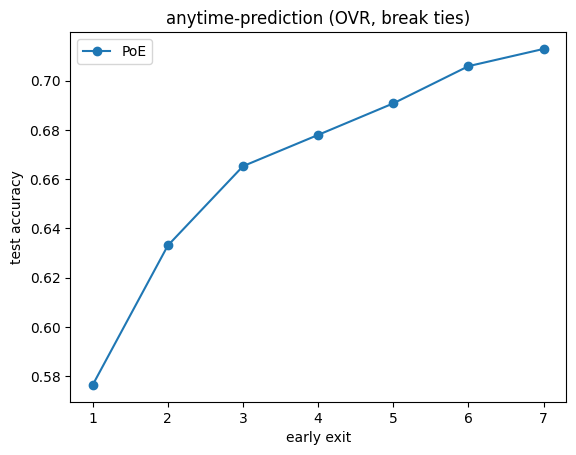

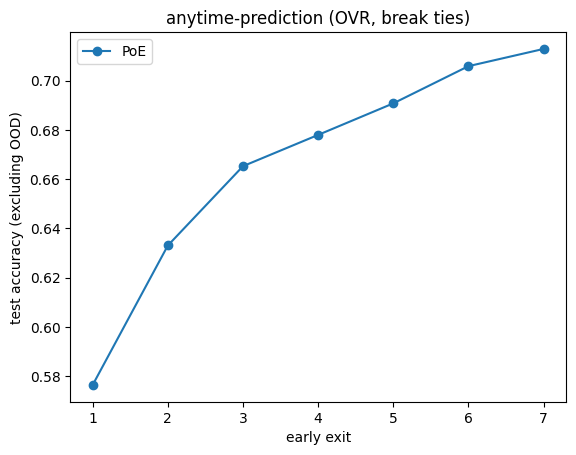

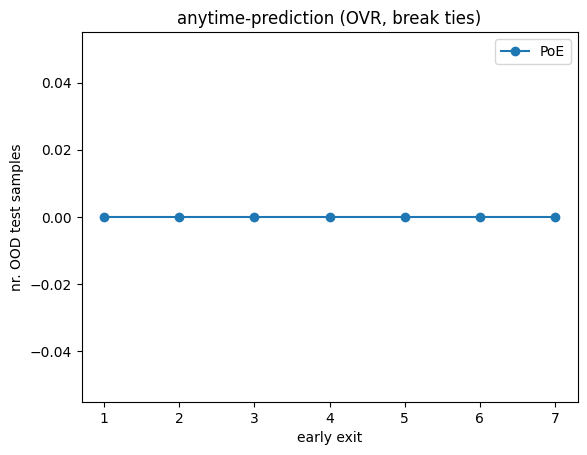

In [143]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc_poe_ovr_break_ties, marker='o', label='PoE')
plt.legend()
plt.title('anytime-prediction (OVR, break ties)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, acc_poe_ovr_excluding_ood_break_ties, marker='o', label='PoE')
plt.legend()
plt.title('anytime-prediction (OVR, break ties)')
plt.ylabel('test accuracy (excluding OOD)')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, nr_ood_poe_ovr_break_ties.values(), marker='o', label='PoE')
plt.legend()
plt.title('anytime-prediction (OVR, break ties)')
plt.ylabel('nr. OOD test samples')
plt.xlabel('early exit')
plt.show()

In [144]:
modal_probs_ovr = modal_probs_decreasing(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, L)
for thres, val in modal_probs_ovr.items():
    print(thres, val)

0.01 0.0
0.05 0.0
0.1 0.0
0.2 0.0
0.5 0.0


## 3 Summary

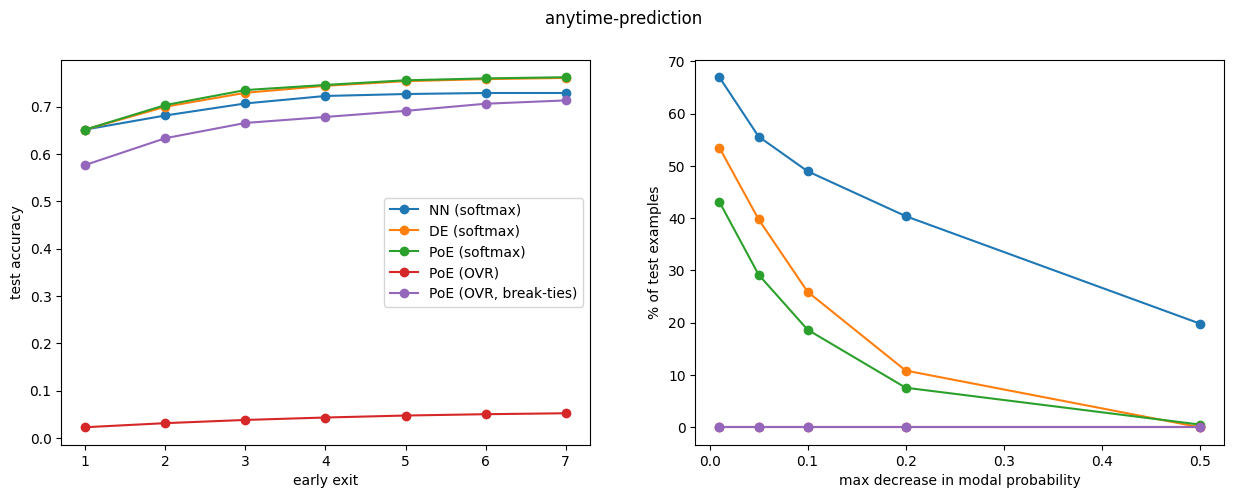

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
early_exits = [i + 1 for i in range(len(acc))]
ax[0].plot(early_exits, acc, label='NN (softmax)', marker='o',)
ax[0].plot(early_exits, acc_de, label='DE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe, label='PoE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr, label='PoE (OVR)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (OVR, break-ties)', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _poe, label in [(preds, probs, 'NN (softmax)'), 
                            (preds_de, probs_de, 'DE (softmax)'), 
                            (preds_poe, probs_poe, 'PoE (softmax)'),
                            (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)')]:
    modal_probs = modal_probs_decreasing(_preds, _poe, L)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle('anytime-prediction')
plt.show()

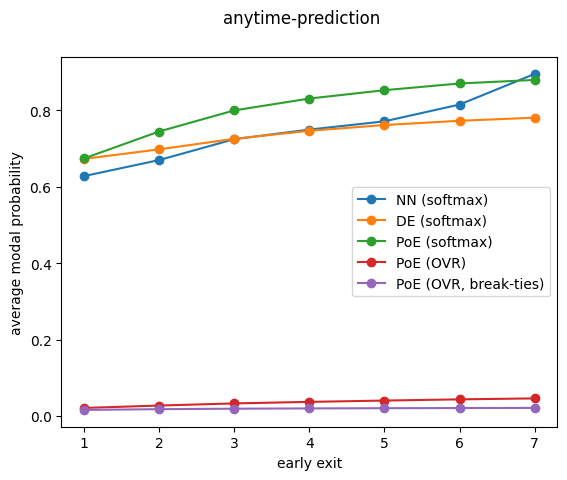

In [146]:
for _preds, _poe, label in [(preds, probs, 'NN (softmax)'), 
                            (preds_de, probs_de, 'DE (softmax)'), 
                            (preds_poe, probs_poe, 'PoE (softmax)'),
                            (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)')]:
    modal_probs = modal_probs_average(_preds, _poe, L)
    plt.plot(early_exits, modal_probs.numpy(), marker='o', label=label)
plt.legend()
plt.xlabel('early exit')
plt.ylabel('average modal probability')


plt.suptitle('anytime-prediction')
plt.show()

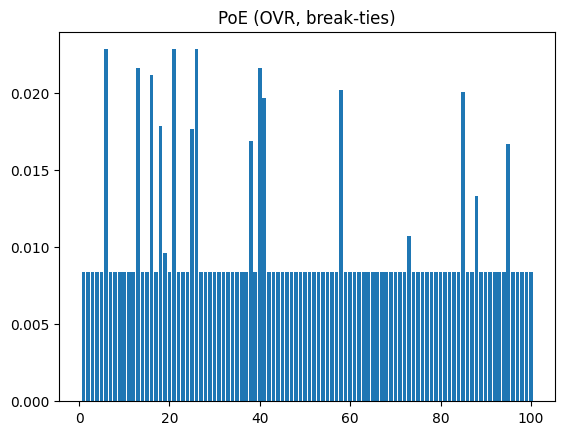

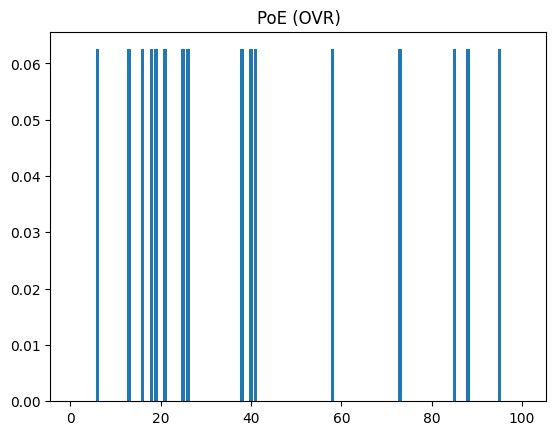

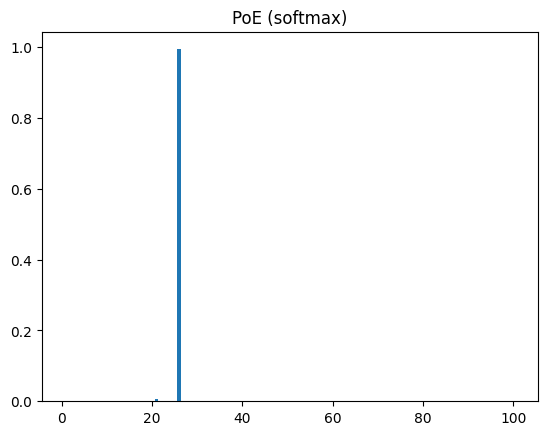

In [147]:
l, n = 6, 110

plt.bar(np.arange(1, 101, 1), probs_poe_ovr_break_ties[l, n, :].numpy())
plt.title('PoE (OVR, break-ties)')
plt.show()

plt.bar(np.arange(1, 101, 1), probs_poe_ovr[l, n, :].numpy())
plt.title('PoE (OVR)')
plt.show()

plt.bar(np.arange(1, 101, 1), probs_poe[l, n, :].numpy())
plt.title('PoE (softmax)')
plt.show()